In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Advance_Projects\Shopper-Spectrum\data\online_retail_data.csv")
sns.set_style(style="whitegrid") 

In [4]:
df.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


**Data Exploration**

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
df.shape

(406829, 8)

In [5]:
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Exclude cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows with negative or zero quantity or unit price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


**Exploratory Data Analysis[EDA]**

In [6]:
country_counts = df['Country'].value_counts()

# Top-selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Daily purchase trends
df['InvoiceDateOnly'] = df['InvoiceDate'].dt.date
daily_sales = df.groupby('InvoiceDateOnly')['Quantity'].sum()

# Transaction monetary distribution
transaction_monetary = df.groupby('InvoiceNo')['TotalPrice'].sum()

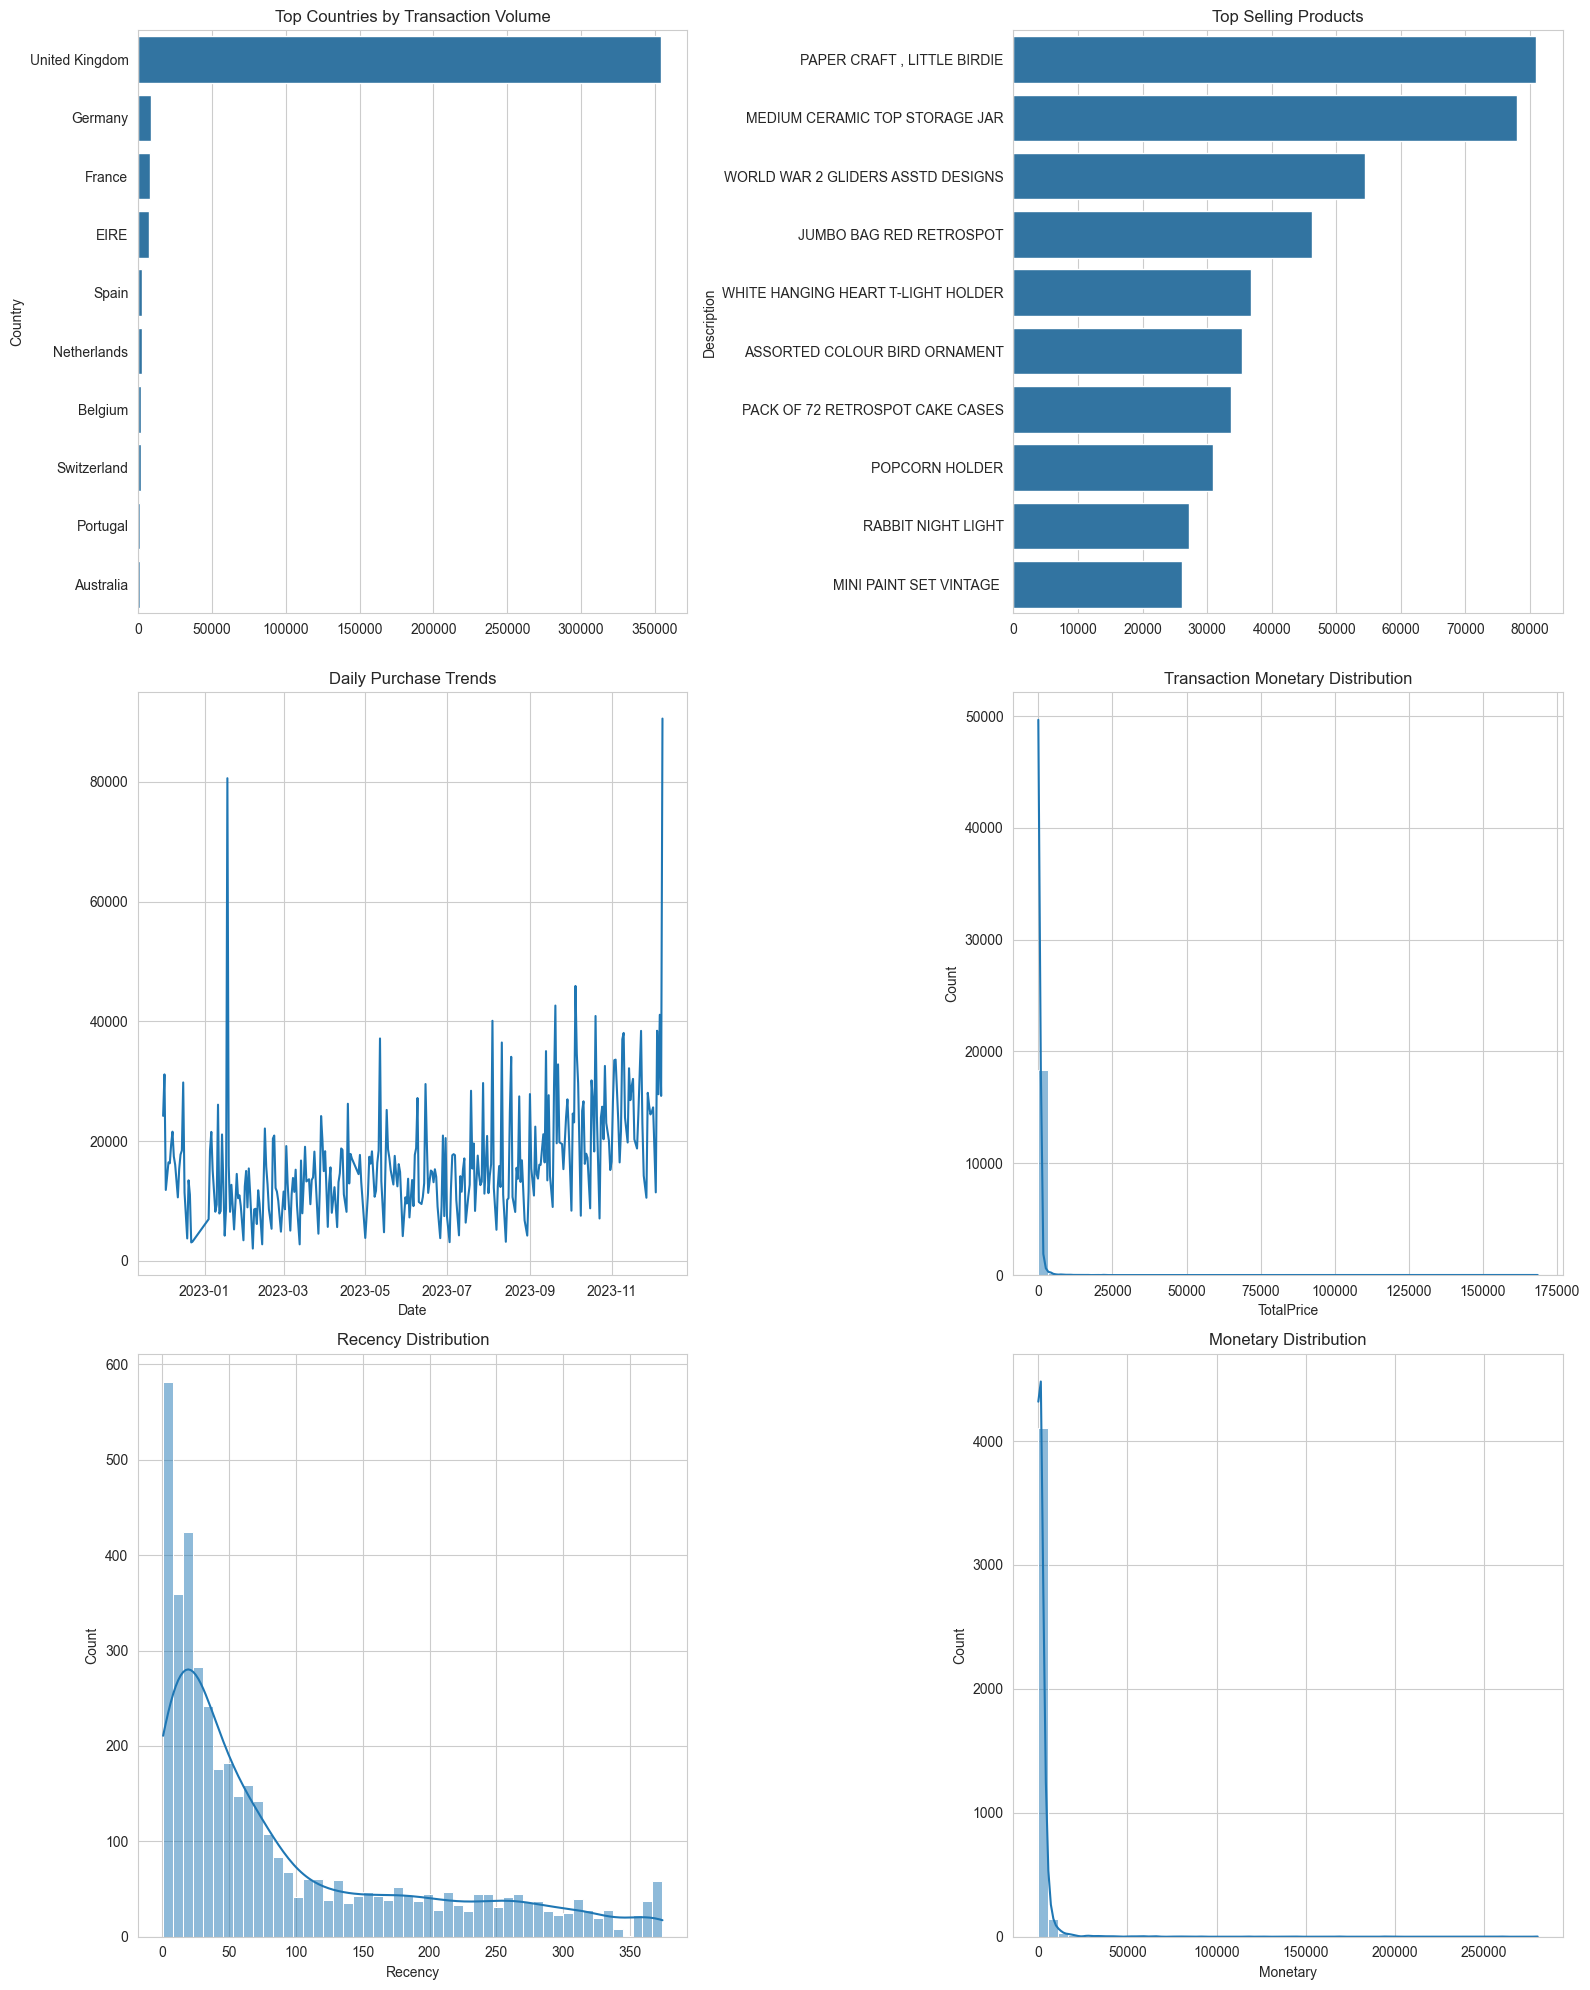

In [7]:
# RFM setup
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Plots
plt.figure(figsize=(16, 20))

plt.subplot(3, 2, 1)
sns.barplot(y=country_counts.head(10).index, x=country_counts.head(10).values)
plt.title("Top Countries by Transaction Volume")

plt.subplot(3, 2, 2)
sns.barplot(y=top_products.index, x=top_products.values)
plt.title("Top Selling Products")

plt.subplot(3, 2, 3)
daily_sales.plot()
plt.title("Daily Purchase Trends")
plt.xlabel("Date")

plt.subplot(3, 2, 4)
sns.histplot(transaction_monetary, bins=50, kde=True)
plt.title("Transaction Monetary Distribution")

plt.subplot(3, 2, 5)
sns.histplot(rfm['Recency'], bins=50, kde=True)
plt.title("Recency Distribution")

plt.subplot(3, 2, 6)
sns.histplot(rfm['Monetary'], bins=50, kde=True)
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()

**Clustering Methodology (RFM + KMeans)**

c:\a\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\a\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\a\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\a\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\a\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of 

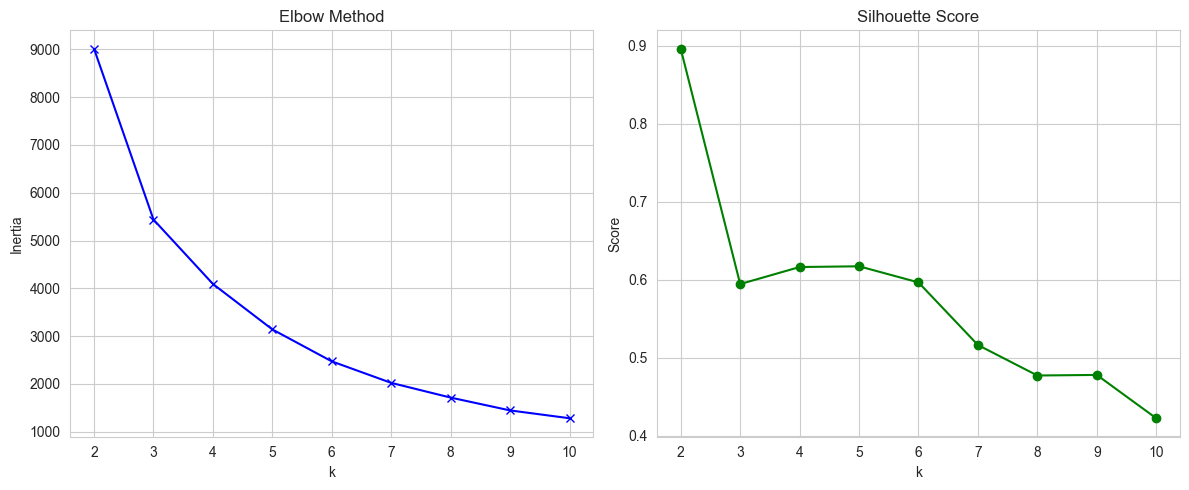

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Standardize RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow & Silhouette methods
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot elbow and silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [9]:
# Final clustering
optimal_k = 4  # based on elbow/silhouette result
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Average RFM per cluster
rfm_summary = rfm.groupby('Cluster').mean().round(1)
print(rfm_summary)

# Optional: Label segments
def segment_label(row):
    if row['Recency'] < rfm['Recency'].median() and row['Frequency'] > rfm['Frequency'].median() and row['Monetary'] > rfm['Monetary'].median():
        return 'High-Value'
    elif row['Frequency'] > rfm['Frequency'].median():
        return 'Regular'
    elif row['Recency'] > rfm['Recency'].median():
        return 'At-Risk'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(segment_label, axis=1)


c:\a\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         Recency  Frequency  Monetary
Cluster                              
0          248.6        1.6     478.1
1           15.7       22.0   12453.2
2            7.4       82.5  127338.3
3           43.9        3.7    1350.1


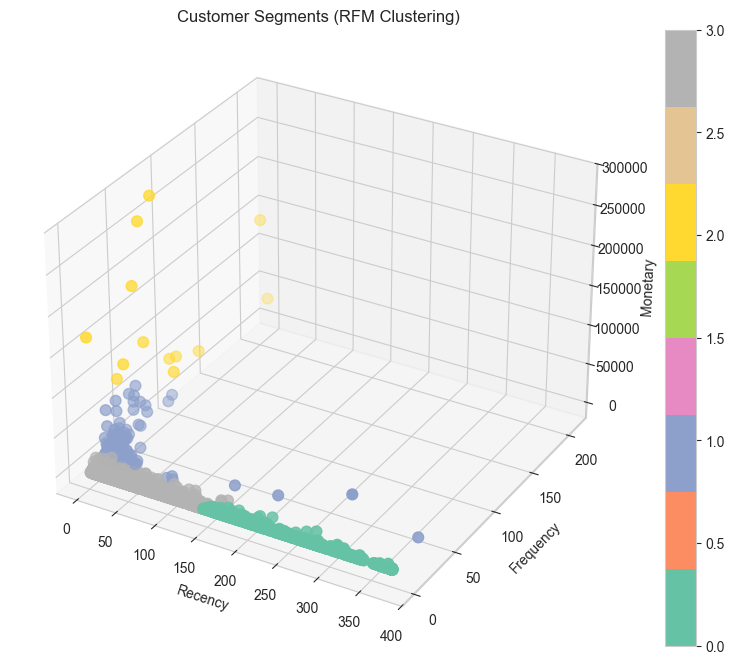

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
                c=rfm['Cluster'], cmap='Set2', s=60)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title("Customer Segments (RFM Clustering)")
plt.colorbar(sc)
plt.show()


**Item-Based Collaborative Filtering**

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np

# Filter to relevant data
df_recommend = df[['CustomerID', 'StockCode', 'Description', 'Quantity']].copy()

# Create the user-item matrix (CustomerID–StockCode)
user_item_matrix = df_recommend.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Normalize the matrix (optional but improves cosine similarity)
item_matrix = normalize(user_item_matrix.T)  # Transpose: items x users

# Compute cosine similarity
similarity = cosine_similarity(item_matrix)

# Map index to product name
item_names = user_item_matrix.columns
item_index = {item: idx for idx, item in enumerate(item_names)}


In [12]:
def get_similar_products(product_name, top_n=5):
    if product_name not in item_index:
        return f"'{product_name}' not found in the product list."

    idx = item_index[product_name]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]  # Skip the same product
    recommendations = [(item_names[i], round(score, 3)) for i, score in sim_scores]
    
    return recommendations


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_heatmap(product_name, top_n=5):
    recs = get_similar_products(product_name, top_n)
    if isinstance(recs, str):
        print(recs)
        return
    
    items = [product_name] + [r[0] for r in recs]
    sim_matrix = cosine_similarity(
        user_item_matrix[items].T
    )
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, xticklabels=items, yticklabels=items, annot=True, cmap='YlGnBu')
    plt.title(f"Item Similarity Heatmap for '{product_name}'")
    plt.show()


In [18]:
# Try with an actual product name from your dataset
example_product = "WHITE HANGING HEART T-LIGHT HOLDER"
recommendations = get_similar_products(example_product)

print(f"\nTop 5 recommendations for: '{example_product}'\n")
for i, (prod, score) in enumerate(recommendations, 1):
    print(f"{i}. {prod} (similarity: {score})")


Top 5 recommendations for: 'WHITE HANGING HEART T-LIGHT HOLDER'

1. GIN + TONIC DIET METAL SIGN (similarity: 0.75)
2. RED HANGING HEART T-LIGHT HOLDER (similarity: 0.659)
3. WASHROOM METAL SIGN (similarity: 0.644)
4. LAUNDRY 15C METAL SIGN (similarity: 0.642)
5. GREEN VINTAGE SPOT BEAKER (similarity: 0.631)


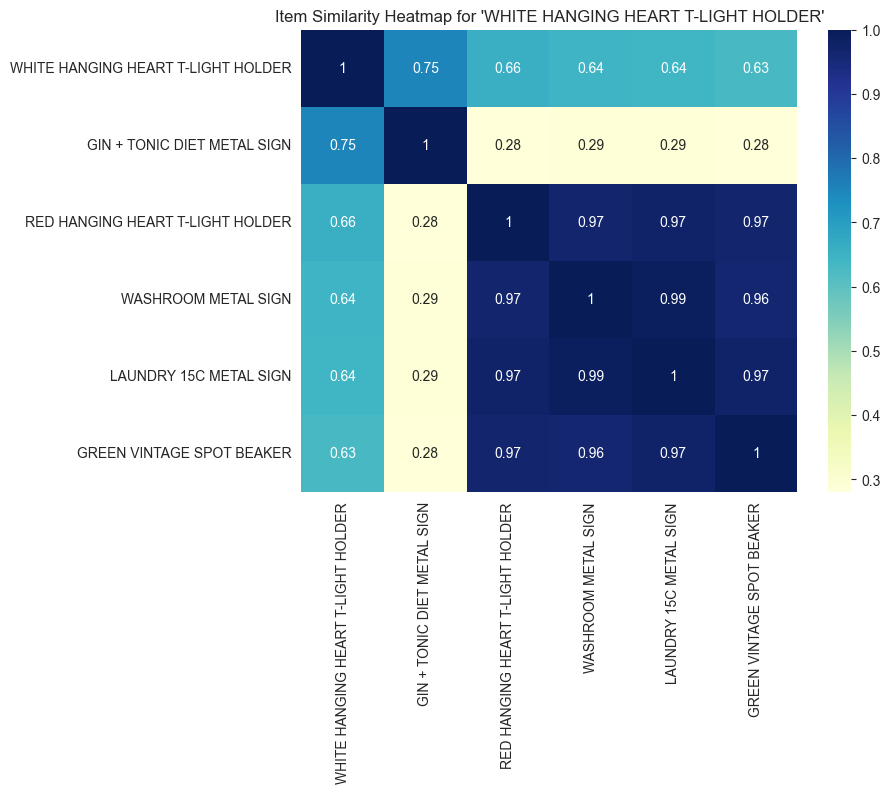

In [17]:
plot_similarity_heatmap("WHITE HANGING HEART T-LIGHT HOLDER")